# TO DOWNLOAD THE DATASET RUN THE download.sh file PROVIDED. THEN run below commands in terminal

1."chmod +x download.sh"

2."./download.sh afhq-dataset"


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import random
import time
from torch.optim import Adam
from scipy import linalg
from torchvision.models import inception_v3
import math


In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Hyperparameters

In [ ]:

image_size = 64
channels = 3
batch_size = 64
learning_rate = 1e-4
num_epochs = 50

# U-Net for DDPM Noise Model

In [ ]:


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        # If mid_channels is not provided, set it to out_channels
        if not mid_channels:
            mid_channels = out_channels
        
        # Define a sequential block of two convolutional layers with GroupNorm and GELU activation
        self.double_conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),  # Group normalization with 1 group
            nn.GELU(),  # GELU activation function
            
            # Second convolutional layer
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),  # Group normalization with 1 group
            nn.GELU()  # GELU activation function
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # mid_channels = in_channels // 2  (just used inside DoubleConv)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        # Upsample the input x1
        x1 = self.up(x1)
        
        # Calculate the difference in height and width between x1 and x2
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        
        # Pad x1 to match the size of x2
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        
        # Concatenate x2 and the padded x1 along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        
        # Apply the convolutional block to the concatenated tensor
        return self.conv(x)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim  # Dimension of the embedding

    def forward(self, time):
        device = time.device  # Get the device of the input tensor
        half_dim = self.dim // 2  # Half of the embedding dimension

        # Compute frequencies for the sinusoidal embeddings
        freqs = torch.exp(
            -math.log(10000) * torch.arange(half_dim, device=device) / (half_dim - 1)
        )

        # Compute the sinusoidal and cosinusoidal components
        args = time[:, None].float() * freqs[None]

        # Concatenate sine and cosine components along the last dimension
        return torch.cat([args.sin(), args.cos()], dim=-1)

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256):
        super().__init__()
        self.time_dim = time_dim

        # encoder
        self.inc   = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        # bottleneck
        self.bot1 = DoubleConv(512, 1024)
        self.bot2 = DoubleConv(1024, 1024)
        self.bot3 = DoubleConv(1024, 512)

        # decoder: corrected channel sums for each Up
        # up1: 512 (bot3 out) + 256 (down2 out) = 768
        self.up1 = Up(512 + 256, 256)
        # up2: 256 (up1 out)  + 128 (down1 out) = 384
        self.up2 = Up(256 + 128, 128)
        # up3: 128 (up2 out)  +  64 (inc out)   = 192
        self.up3 = Up(128 + 64,   64)

        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        # time embeddings
        self.time_mlp   = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )
        self.time_inc   = nn.Linear(time_dim, 64)
        self.time_down1 = nn.Linear(time_dim, 128)
        self.time_down2 = nn.Linear(time_dim, 256)
        self.time_down3 = nn.Linear(time_dim, 512)
        self.time_bot1  = nn.Linear(time_dim, 1024)
        self.time_bot2  = nn.Linear(time_dim, 1024)
        self.time_bot3  = nn.Linear(time_dim, 512)
        self.time_up1   = nn.Linear(time_dim, 256)
        self.time_up2   = nn.Linear(time_dim, 128)
        self.time_up3   = nn.Linear(time_dim, 64)

    def forward(self, x, t):
        # time embeddings
        t = self.time_mlp(t)

        x1 = self.inc(x)
        x1 = x1 + self.time_inc(t)[:, :, None, None]

        x2 = self.down1(x1)
        x2 = x2 + self.time_down1(t)[:, :, None, None]

        x3 = self.down2(x2)
        x3 = x3 + self.time_down2(t)[:, :, None, None]

        x4 = self.down3(x3)
        x4 = x4 + self.time_down3(t)[:, :, None, None]

        x4 = self.bot1(x4)
        x4 = x4 + self.time_bot1(t)[:, :, None, None]

        x4 = self.bot2(x4)
        x4 = x4 + self.time_bot2(t)[:, :, None, None]

        x4 = self.bot3(x4)
        x4 = x4 + self.time_bot3(t)[:, :, None, None]

        x  = self.up1(x4, x3)
        x  = x + self.time_up1(t)[:, :, None, None]
        x  = self.up2(x,  x2)
        x  = x + self.time_up2(t)[:, :, None, None]
        x  = self.up3(x,  x1)
        x  = x + self.time_up3(t)[:, :, None, None]

        return self.outc(x)


# Diffusion Process Wrapper

In [ ]:

class DiffusionModel:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):

        self.timesteps = timesteps
        # Linearly spaced beta values for the diffusion process
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1. - self.betas
        # Compute the cumulative product of alphas over timesteps
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        # Compute the cumulative product of alphas for the previous timestep, padded with 1.0 at the start
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        # Compute the square root of the cumulative product of alphas
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def forward_diffusion(self, x0, t):
        # Generate random noise with the same shape as the input x0
        noise = torch.randn_like(x0)

        # Compute the scaling factor for the input x0 based on the square root of the cumulative product of alphas
        sa = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)

        # Compute the scaling factor for the noise based on the square root of one minus the cumulative product of alphas
        sb = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        return sa * x0 + sb * noise, noise

    @torch.no_grad()
    def sample_timestep(self, model, x, t):
        betas_t = self.betas[t].reshape(-1,1,1,1)
        sb = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1,1,1,1)
        sr = self.sqrt_recip_alphas[t].reshape(-1,1,1,1)
        model_mean = sr * (x - betas_t * model(x, t) / sb)
        if t[0] == 0:
            return model_mean
        var = self.posterior_variance[t].reshape(-1,1,1,1)
        return model_mean + torch.sqrt(var) * torch.randn_like(x)

    @torch.no_grad()
    def sample(self, model, n_samples, size=None):
        if size is None:
            size = image_size
        img = torch.randn((n_samples, channels, size, size), device=device)
        for i in tqdm(reversed(range(self.timesteps)), desc='Sampling', total=self.timesteps):
            t = torch.full((n_samples,), i, device=device, dtype=torch.long)
            img = self.sample_timestep(model, img, t)
        return (img.clamp(-1,1) + 1) / 2


# Data Loader

In [ ]:

def get_data_loader(data_dir, batch_size=32, image_size=64):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])
    dataset = ImageFolder(root=data_dir, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

# Training & Utilities

In [ ]:
def train_diffusion_model(model, diffusion, dataloader, num_epochs=50, lr=1e-4, save_dir='results'):
    optimizer = Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()  # Mean Squared Error loss function
    model.train()      # Set the model to training mode
    os.makedirs(save_dir, exist_ok=True)
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False) as tepoch:
            for step, (images, _) in enumerate(tepoch):
                images = images.to(device)
                b = images.shape[0]
                optimizer.zero_grad()
                t = torch.randint(0, diffusion.timesteps, (b,), device=device).long()
                x_t, noise = diffusion.forward_diffusion(images, t)
                pred_noise = model(x_t, t)
                loss = mse(pred_noise, noise)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
        avg = running_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}] → Loss: {avg:.6f}')
        torch.save(model.state_dict(), f"{save_dir}/model_epoch{epoch}.pt")
    return model


# Save model

In [ ]:

def generate_and_save(model, diffusion, n_samples=100, save_path='generated.png', nrow=10):
    model.eval()
    samples = diffusion.sample(model, n_samples)
    grid = make_grid(samples, nrow=nrow)
    save_image(grid, save_path)
    plt.imshow(grid.permute(1,2,0).cpu())
    plt.axis('off')
    plt.savefig(save_path)
    plt.close()
    return samples

# Caluctae FIDS

In [ ]:
def calculate_fid(real_images, gen_images):
    inc = inception_v3(pretrained=True, transform_input=False).to(device)
    inc.fc = nn.Identity()
    inc.eval()
    def get_feats(x):
        feats = []
        for i in range(0, x.size(0), 32):
            batch = x[i:i+32]
            batch = F.interpolate(batch, size=(299,299), mode='bilinear')
            with torch.no_grad():
                feats.append(inc(batch).cpu().numpy())
        return np.concatenate(feats, axis=0)
    f1 = get_feats(real_images)
    f2 = get_feats(gen_images)
    mu1, mu2 = f1.mean(0), f2.mean(0)
    s1, s2 = np.cov(f1, rowvar=False), np.cov(f2, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(s1.dot(s2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(s1 + s2 - 2*covmean)

# Main Experiment Loop with 100,500,1000 Time Steps

In [ ]:
def main():
    data_dir = "/data3/mohan/Assignment-3/data/afhq"
    dataloader = get_data_loader(data_dir, batch_size, image_size=image_size)
    real_batch = next(iter(dataloader))[0].to(device)

    results = {}
    for timesteps in [100]:
        print(f"\n=== Timesteps: {timesteps} ===")
        model = UNet(c_in=channels, c_out=channels, time_dim=256).to(device)
        diffusion = DiffusionModel(timesteps=timesteps)
        save_dir = f"results_{timesteps}"
        os.makedirs(save_dir, exist_ok=True)

        # Train
        train_diffusion_model(model, diffusion, dataloader, num_epochs, learning_rate, save_dir)

        # Generate
        samples = generate_and_save(model, diffusion, n_samples=100,
                                    save_path=f"{save_dir}/grid.png", nrow=10)

        # FID
        fid = calculate_fid(real_batch, samples[:batch_size])
        print(f"→ FID @ {timesteps}: {fid:.4f}")
        results[timesteps] = fid

    print("\n=== FID Comparison ===")
    for t, v in results.items():
        print(f"Timesteps {t}: FID = {v:.4f}")

if __name__ == "__main__":
    main()


Using device: cuda

=== Timesteps: 100 ===


Epoch [1/50] → Loss: 0.264165


Epoch [2/50] → Loss: 0.133337


Epoch [3/50] → Loss: 0.114934


Epoch [4/50] → Loss: 0.110728


Epoch [5/50] → Loss: 0.105609


Epoch [6/50] → Loss: 0.102229


Epoch [7/50] → Loss: 0.099047


Epoch [8/50] → Loss: 0.096844


Epoch [9/50] → Loss: 0.092337


Epoch [10/50] → Loss: 0.092286


Epoch [11/50] → Loss: 0.090945


Epoch [12/50] → Loss: 0.090517


Epoch [13/50] → Loss: 0.088735


Epoch [14/50] → Loss: 0.087445


Epoch [15/50] → Loss: 0.087501


Epoch [16/50] → Loss: 0.086552


Epoch [17/50] → Loss: 0.086366


Epoch [18/50] → Loss: 0.084745


Epoch [19/50] → Loss: 0.085159


Epoch [20/50] → Loss: 0.084880


Epoch [21/50] → Loss: 0.084151


Epoch [22/50] → Loss: 0.082990


Epoch [23/50] → Loss: 0.083739


Epoch [24/50] → Loss: 0.082176


Epoch [25/50] → Loss: 0.081944


Epoch [26/50] → Loss: 0.082563


Epoch [27/50] → Loss: 0.081069


Epoch [28/50] → Loss: 0.080715


Epoch [29/50] → Loss: 0.079880


Epoch [30/50] → Loss: 0.080078


Epoch [31/50] → Loss: 0.079680


Epoch [32/50] → Loss: 0.080343


Epoch [33/50] → Loss: 0.077745


Epoch [34/50] → Loss: 0.078622


Epoch [35/50] → Loss: 0.078361


Epoch [36/50] → Loss: 0.078385


Epoch [37/50] → Loss: 0.079584


Epoch [38/50] → Loss: 0.078163


Epoch [39/50] → Loss: 0.078427


Epoch [40/50] → Loss: 0.078080


Epoch [41/50] → Loss: 0.077687


Epoch [42/50] → Loss: 0.078938


Epoch [43/50] → Loss: 0.077963


Epoch [44/50] → Loss: 0.078616


Epoch [45/50] → Loss: 0.077980


Epoch [46/50] → Loss: 0.077901


Epoch [47/50] → Loss: 0.076750


Epoch [48/50] → Loss: 0.075767


Epoch [49/50] → Loss: 0.076569


Epoch [50/50] → Loss: 0.077033


Sampling: 100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


→ FID @ 100: 237.5298

=== FID Comparison ===
Timesteps 100: FID = 237.5298


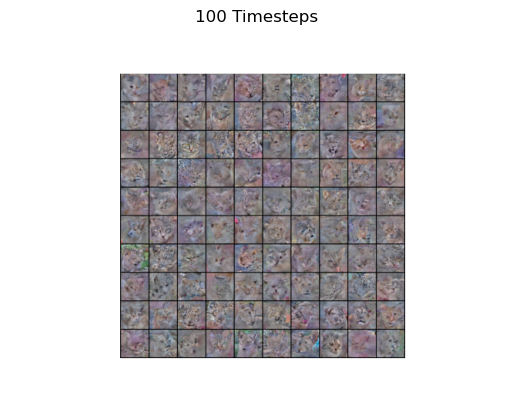

Using device: cuda

=== Timesteps: 500 ===
                                                                          
Epoch [1/50] → Loss: 0.203238
                                                                          
Epoch [2/50] → Loss: 0.080597
                                                                          
Epoch [3/50] → Loss: 0.064771
                                                                          
Epoch [4/50] → Loss: 0.059378
                                                                          
Epoch [5/50] → Loss: 0.055813
                                                                          
Epoch [6/50] → Loss: 0.053486
                                                                          
Epoch [7/50] → Loss: 0.051360
                                                                          
Epoch [8/50] → Loss: 0.049713
                                                                          
Epoch [9/50] → Loss: 0.047802
                                                                           
Epoch [10/50] → Loss: 0.047978
                                                                           
Epoch [11/50] → Loss: 0.047246
                                                                           
Epoch [12/50] → Loss: 0.046577
                                                                           
Epoch [13/50] → Loss: 0.045046
                                                                           
Epoch [14/50] → Loss: 0.045408
                                                                           
Epoch [15/50] → Loss: 0.045335
                                                                           
Epoch [16/50] → Loss: 0.043640
                                                                           
Epoch [17/50] → Loss: 0.043885
                                                                           
Epoch [18/50] → Loss: 0.043169
                                                                           
Epoch [19/50] → Loss: 0.043671
                                                                           
Epoch [20/50] → Loss: 0.043188
                                                                           
Epoch [21/50] → Loss: 0.042875
                                                                           
Epoch [22/50] → Loss: 0.042632
                                                                           
Epoch [23/50] → Loss: 0.042367
                                                                           
Epoch [24/50] → Loss: 0.041027
                                                                           
Epoch [25/50] → Loss: 0.040955
                                                                           
Epoch [26/50] → Loss: 0.040890
                                                                           
Epoch [27/50] → Loss: 0.040815
                                                                           
Epoch [28/50] → Loss: 0.040600
                                                                           
Epoch [29/50] → Loss: 0.040519
                                                                           
Epoch [30/50] → Loss: 0.040669
                                                                           
Epoch [31/50] → Loss: 0.040971
                                                                           
Epoch [32/50] → Loss: 0.039740
                                                                           
Epoch [33/50] → Loss: 0.039126
                                                                           
Epoch [34/50] → Loss: 0.038820
                                                                           
Epoch [35/50] → Loss: 0.040455
                                                                           
Epoch [36/50] → Loss: 0.039523
                                                                           
Epoch [37/50] → Loss: 0.040649
                                                                           
Epoch [38/50] → Loss: 0.039509
                                                                           
Epoch [39/50] → Loss: 0.038662
                                                                           
Epoch [40/50] → Loss: 0.038967
                                                                           
Epoch [41/50] → Loss: 0.039276
                                                                           
Epoch [42/50] → Loss: 0.038704
                                                                           
Epoch [43/50] → Loss: 0.039357
                                                                           
Epoch [44/50] → Loss: 0.038292
                                                                           
Epoch [45/50] → Loss: 0.039246
                                                                           
Epoch [46/50] → Loss: 0.038583
                                                                           
Epoch [47/50] → Loss: 0.038257
                                                                           
Epoch [48/50] → Loss: 0.038001
                                                                           
Epoch [49/50] → Loss: 0.037223
                                                                           
Epoch [50/50] → Loss: 0.037778
Sampling: 100%|██████████| 500/500 [01:51<00:00,  4.48it/s]
/data3/rishubh/anaconda3/envs/blender_kmk/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data3/rishubh/anaconda3/envs/blender_kmk/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
→ FID @ 500: 188.2755

=== FID Comparison ===

Timesteps 500: FID = 188.2755

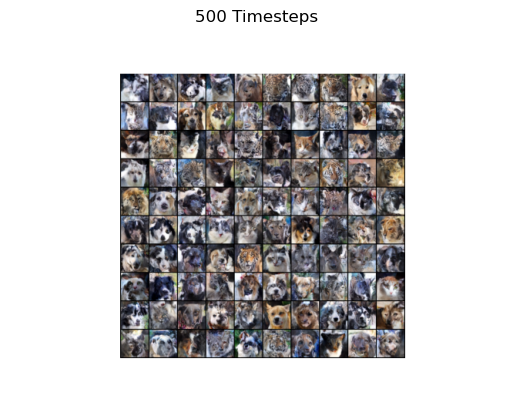

Using device: cuda

=== Timesteps: 1000 ===
                                                                          
Epoch [1/50] → Loss: 0.185058
                                                                          
Epoch [2/50] → Loss: 0.064267
                                                                          
Epoch [3/50] → Loss: 0.049950
                                                                          
Epoch [4/50] → Loss: 0.044724
                                                                          
Epoch [5/50] → Loss: 0.041725
                                                                          
Epoch [6/50] → Loss: 0.039504
                                                                          
Epoch [7/50] → Loss: 0.037888
                                                                          
Epoch [8/50] → Loss: 0.037004
                                                                          
Epoch [9/50] → Loss: 0.035325
                                                                           
Epoch [10/50] → Loss: 0.034775
                                                                           
Epoch [11/50] → Loss: 0.034974
                                                                           
Epoch [12/50] → Loss: 0.033112
                                                                           
Epoch [13/50] → Loss: 0.033290
                                                                           
Epoch [14/50] → Loss: 0.032867
                                                                           
Epoch [15/50] → Loss: 0.032641
                                                                           
Epoch [16/50] → Loss: 0.032013
                                                                           
Epoch [17/50] → Loss: 0.031890
                                                                           
Epoch [18/50] → Loss: 0.031546
                                                                           
Epoch [19/50] → Loss: 0.031889
                                                                           
Epoch [20/50] → Loss: 0.030899
                                                                           
Epoch [21/50] → Loss: 0.030094
                                                                           
Epoch [22/50] → Loss: 0.030967
                                                                           
Epoch [23/50] → Loss: 0.030383
                                                                           
Epoch [24/50] → Loss: 0.029558
                                                                           
Epoch [25/50] → Loss: 0.029280
                                                                           
Epoch [26/50] → Loss: 0.029489
                                                                           
Epoch [27/50] → Loss: 0.028794
                                                                           
Epoch [28/50] → Loss: 0.029381
                                                                           
Epoch [29/50] → Loss: 0.029078
                                                                           
Epoch [30/50] → Loss: 0.029498
                                                                           
Epoch [31/50] → Loss: 0.029341
                                                                           
Epoch [32/50] → Loss: 0.028964
                                                                           
Epoch [33/50] → Loss: 0.027280
                                                                           
Epoch [34/50] → Loss: 0.027903
                                                                           
Epoch [35/50] → Loss: 0.028143
                                                                           
Epoch [36/50] → Loss: 0.028074
                                                                           
Epoch [37/50] → Loss: 0.028180
                                                                           
Epoch [38/50] → Loss: 0.028386
                                                                           
Epoch [39/50] → Loss: 0.027268
                                                                           
Epoch [40/50] → Loss: 0.027286
                                                                           
Epoch [41/50] → Loss: 0.027647
                                                                           
Epoch [42/50] → Loss: 0.027577
                                                                           
Epoch [43/50] → Loss: 0.027609
                                                                           
Epoch [44/50] → Loss: 0.026416
                                                                           
Epoch [45/50] → Loss: 0.028388
                                                                           
Epoch [46/50] → Loss: 0.026845
                                                                           
Epoch [47/50] → Loss: 0.027149
                                                                           
Epoch [48/50] → Loss: 0.027482
                                                                           
Epoch [49/50] → Loss: 0.026688
                                                                           
Epoch [50/50] → Loss: 0.026862
Sampling: 100%|██████████| 1000/1000 [03:43<00:00,  4.47it/s]
→ FID @ 1000: 210.2537

=== FID Comparison ===

Timesteps 1000: FID = 210.2537

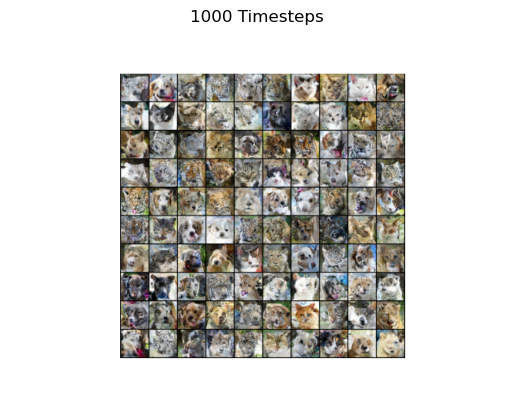